In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from dataset import EEGDataset
from filter  import Filter
from sklearn.model_selection import train_test_split

In [2]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"

In [3]:
data = loadmat(file_path_1)
[x[0] for x in data['nfo']['classes'][0][0][0]]

['left', 'foot']

In [4]:
data = EEGDataset(file_path_1, 2)

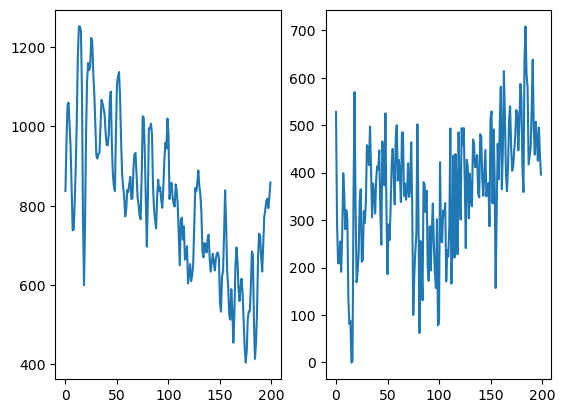

In [5]:
transformed = Filter.laplacian_filter(data)
plt.subplot(1, 2, 1)
plt.plot(data.trials[10][20])
plt.subplot(1, 2, 2)
plt.plot(transformed[10][20])
plt.show()

In [6]:
shape = data.trials.shape

In [7]:
X = data.trials.reshape(data.n_trails, -1)
y = data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

In [8]:
np.unique(y_test, return_counts=True)

(array([-1,  1], dtype=int16), array([25, 25]))

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.64

## SVM

In [10]:
from sklearn.svm import SVC

model = SVC(kernel='rbf', C=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.5

## KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.54

## MLP

In [12]:
from mlp import TorchDataset, MLP, NNTrainTest
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

In [13]:
num_classes = 2
num_epochs = 2
batch_size = 64
learning_rate = 0.001
input_shape = (-1, 59 * 200)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mlp_clf = MLP(input_shape, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_clf.parameters(), lr=learning_rate)

NNTrainTest(mlp_clf, device).train(num_epochs, TorchDataset(X_train, y_train), batch_size, learning_rate)

NNTrainTest(mlp_clf, device).test(TorchDataset(X_test, y_test), batch_size)

Accuracy on test dataset: 46.0%


In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = data.trials[0]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = X.shape[1]

pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_reconstructed = pca.inverse_transform(X_pca)
reconstruction_error = np.mean(np.abs(X - X_reconstructed))
print(f'Reconstruction error: {reconstruction_error:.4f}')


Reconstruction error: 1091.0939
